In [43]:
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

import itertools as it
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [4]:
def load_emb(path, total=None):
    toks = []
    embs = []
    with open(path, 'r') as f:
        for l in tqdm(f, path, total=total):
            tok, *emb = l.strip().split()
            emb = [float(x) for x in emb]
            toks.append(tok)
            embs.append(emb)
    assert('PAD_TOK' not in toks and 'UNK_TOK' not in toks)
    toks += ['PAD_TOK', 'UNK_TOK']
    embs += [[0.]*len(emb), [0.]*len(emb)]
    tok_to_id = dict(zip(toks, it.count()))
    emb = torch.tensor(embs)
    return tok_to_id, emb

In [5]:
#tok_to_id, glv_emb = load_emb('data/glove/glove.6B.100d.txt', int(4e5))
#torch.save((tok_to_id, glv_emb), 'data/pt-cache/tok_to_id__glv_emb.pt')
tok_to_id, glv_emb = torch.load('data/pt-cache/tok_to_id__glv_emb.pt')

In [6]:
def load_chrs(path, total=None):
    chars = set()
    with open(path, 'r') as f:
        for l in tqdm(f, path, total=total):
            try:
                for c in l.strip().split()[2]:
                    chars.add(c)
            except:
                pass
    assert('PAD_CHR' not in chars and 'UNK_CHR' not in chars)
    chars.add('PAD_CHR')
    chars.add('UNK_CHR')
    return dict(zip(chars, it.count()))

In [7]:
#chr_to_id = load_chrs('data/ner-gmb/train.txt')
#torch.save(chr_to_id, 'data/pt-cache/chr_to_id.pt')
chr_to_id = torch.load('data/pt-cache/chr_to_id.pt')

In [8]:
def load_classes(path, total=None):
    id_to_lbl = set()
    with open(path, 'r') as f:
        for l in tqdm(f, path, total=total):
            try:
                id_to_lbl.add(l.strip().split()[3])
            except:
                pass
    assert('PAD_LBL' not in id_to_lbl)
    id_to_lbl.add('PAD_LBL')
    id_to_lbl = list(id_to_lbl)
    lbl_to_id = {k:v for v, k in enumerate(id_to_lbl)}
    return lbl_to_id, id_to_lbl

In [9]:
#lbl_to_id, id_to_lbl = load_classes('data/ner-gmb/train.txt')
#torch.save((lbl_to_id, id_to_lbl), 'data/pt-cache/lbl_to_id__id_to_lbl')
lbl_to_id, id_to_lbl = torch.load('data/pt-cache/lbl_to_id__id_to_lbl')

In [10]:
def load_data(path, tok_to_id, lbl_to_id, chr_to_id, seq_len=128, word_len=64):
    with open(path, 'r') as f:
        seqs = f.read().split('\n\n')
        seqs.pop()
        seqs[0] = seqs[0][1:]
    X = tok_to_id['PAD_TOK'] * torch.ones((len(seqs), seq_len), dtype=torch.long)
    Y = lbl_to_id['PAD_LBL'] * torch.ones((len(seqs), seq_len), dtype=torch.long)
    W = chr_to_id['PAD_CHR'] * torch.ones((len(seqs), seq_len, word_len), dtype=torch.long)
    for i, seq in enumerate(tqdm(seqs, 'sequences')):
        for j, l in enumerate(seq.split('\n')):
            assert(j < seq_len)
            tok, _, wrd, lbl = l.split(' ')
            try:
                X[i,j] = tok_to_id[tok]
            except KeyError:
                X[i,j] = tok_to_id['UNK_TOK']
                
            for k, ch in enumerate(wrd):
                try:
                    W[i,j,k] = chr_to_id[ch]
                except KeyError:
                    W[i,j,k] = chr_to_id['UNK_CHR']
                    
            Y[i,j] = lbl_to_id[lbl]
    return X, Y, W

In [11]:
#train_X, train_Y, train_W = load_data('data/ner-gmb/train.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((train_X, train_Y, train_W), 'data/pt-cache/train_X__train_Y__train_W.pt')
train_X, train_Y, train_W = torch.load('data/pt-cache/train_X__train_Y__train_W.pt')

In [12]:
#dev_X, dev_Y, dev_W = load_data('data/ner-gmb/dev.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((dev_X, dev_Y, dev_W), 'data/pt-cache/dev_X__dev_Y__dev_W.pt')
dev_X, dev_Y, dev_W = torch.load('data/pt-cache/dev_X__dev_Y__dev_W.pt')

In [13]:
#test_X, test_Y, test_W = load_data('data/ner-gmb/test.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((test_X, test_Y, test_W), 'data/pt-cache/test_X__test_Y__test_W.pt')
test_X, test_Y, test_W = torch.load('data/pt-cache/test_X__test_Y__test_W.pt')

In [124]:
class NERModel(nn.Module):
    def __init__(self, embed_model, seq_tag_model, pad_lbl_id, pad_tok_id, class_freq):
        super().__init__()
        self.embed_model = embed_model
        self.seq_tag_model = seq_tag_model
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=1/class_freq.float(), ignore_index=pad_lbl_id)
        self.pad_lbl_id = pad_lbl_id
        self.pad_tok_id = pad_tok_id

    def forward(self, X, truncate=True):
        if truncate:
            max_len = torch.max(torch.sum(X != self.pad_tok_id, dim=-1))
            X = X[...,:max_len]
        return self.seq_tag_model(self.embed_model(X))
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            return torch.argmax(self(X, truncate=False), dim=-1)
        
    def criterion(self, Y, Y_hat):
        Y = Y[...,:Y_hat.shape[-2]]
        return self.cross_entropy_loss(Y_hat.transpose(1,2), Y)
    
    def device(self):
        return next(self.parameters()).device

In [125]:
class SeqTagModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.h0 = nn.Parameter(torch.zeros(2, hidden_size))
        self.c0 = nn.Parameter(torch.zeros(2, hidden_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*hidden_size, output_size)
    
    def forward(self, X):
        D = self.dropout(X)
        H, _ = self.lstm(D,
                         (self.h0[:,None,:].expand(-1,D.shape[0],-1).contiguous(),
                         self.c0[:,None,:].expand(-1,D.shape[0],-1).contiguous()))
        return self.linear(H)

In [126]:
class ChrEmbModel(nn.Module):
    def __init__(self, n_embs, pad_chr_id, input_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(n_embs, input_size, padding_idx=pad_chr_id)
        self.h0 = nn.Parameter(torch.zeros(2, hidden_size))
        self.c0 = nn.Parameter(torch.zeros(2, hidden_size))
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, W):
        X = W.reshape(-1,W.shape[-1])
        E = self.embedding(X)
        _, (H, _) = self.lstm(E, (self.h0.expand(E.shape[0],-1,-1), self.c0.expand(E.shape[0],-1,-1)))
        return H.reshape(*W.shape,-1)

In [127]:
class ChrTokEmbModel(nn.Module):
    def __init__(self, chr_emb_model, tok_emb_model):
        super().__init__()
        self.chr_emb_model = chr_emb_model
        self.tok_emb_model = tok_emb_model
    
    def forward(self, W, X):
        return torch.cat((self.chr_emb_model(W), self.tok_emb_model(X)), dim=-1)

In [139]:
def metrics(Y_true, Y_pred, n_classes):
    with torch.no_grad():
        assert(Y_true.shape == Y_pred.shape)
        Y_true = Y_true.reshape(-1)
        Y_pred = Y_pred.reshape(-1)
        Y_pred = Y_pred[Y_true != n_classes]
        Y_true = Y_true[Y_true != n_classes]
        acc = torch.sum(Y_true == Y_pred).float() / torch.numel(Y_true)
        Z_true = F.one_hot(Y_true, n_classes)
        Z_pred = F.one_hot(Y_pred, n_classes)
        S_tp = torch.sum(Z_true & Z_pred, dim=0).float()
        S_t = torch.sum(Z_true, dim=0).float()
        S_p = torch.sum(Z_pred, dim=0).float()
        micro_F1 = 2 * torch.sum(S_tp) / (torch.sum(S_t) + torch.sum(S_p))
        macro_F1 = torch.mean(2 * S_tp / (S_t + S_p))
        return [acc.item(), micro_F1.item(), macro_F1.item()]

In [140]:
def train_epoch(model, opt, train_loader, dev_loader, grad_clip_norm):
    train_losses = []
    dev_losses = []
    for (train_X_batch, train_Y_batch), (dev_X_batch, dev_Y_batch) in \
    zip(tqdm(train_loader, 'batches'), it.cycle(dev_loader)):
        with torch.no_grad():
            model.eval()
            dev_X_batch = dev_X_batch.to(model.device())
            dev_Y_batch = dev_Y_batch.to(model.device())
            dev_loss = model.criterion(dev_Y_batch, model(dev_X_batch))
            dev_losses.append(dev_loss.item())

        model.train()
        train_X_batch = train_X_batch.to(model.device())
        train_Y_batch = train_Y_batch.to(model.device())
        train_loss = model.criterion(train_Y_batch, model(train_X_batch))
        train_losses.append(train_loss.item())
        opt.zero_grad()
        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
        opt.step()
    return train_losses, dev_losses

In [165]:
def plot_losses(train_losses, dev_losses, new_train_losses, new_dev_losses):
    plt.subplot(121)
    plt.plot(dev_losses, label='dev')
    plt.plot(train_losses, label='train')
    plt.legend()
    plt.title('All Epochs')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.subplot(122)
    plt.plot(new_dev_losses, label='dev')
    plt.plot(new_train_losses, label='train')
    plt.legend()
    plt.title('Last Epoch')
    plt.xlabel('iterations')
    plt.ylabel('loss')

In [142]:
def plot_metrics(train_metrics_np, dev_metrics_np):
    plt.subplot(131)
    plt.plot(train_metrics_np[:,0], 'x', label='train')
    plt.plot(dev_metrics_np[:,0], 'x', label='dev')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylim(0,1)
    plt.subplot(132)
    plt.plot(train_metrics_np[:,1], 'x', label='train')
    plt.plot(dev_metrics_np[:,1], 'x', label='dev')
    plt.legend()
    plt.suptitle('Micro-F1')
    plt.xlabel('epochs')
    plt.ylim(0,1)
    plt.subplot(133)
    plt.plot(train_metrics_np[:,2], 'x', label='train')
    plt.plot(dev_metrics_np[:,2], 'x', label='dev')
    plt.legend()
    plt.title('Macro-F1')
    plt.xlabel('epochs')
    plt.ylim(0,1)

In [143]:
def batch_predict(model, X, batch_size):
    loader = data.DataLoader(data.TensorDataset(X), batch_size=batch_size)
    return torch.cat([model.predict(batch.to(model.device())) for batch, *_ in loader])

In [168]:
def train_loop(train_X, train_Y, dev_X, dev_Y, model, opt, n_classes, batch_size, grad_clip_norm):
    train_losses = []
    dev_losses = []
    train_metrics = []
    dev_metrics = []
    train_loader = data.DataLoader(data.TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)
    dev_loader = data.DataLoader(data.TensorDataset(dev_X, dev_Y), batch_size=batch_size, shuffle=True)
    while True:
        new_train_losses, new_dev_losses = train_epoch(model, opt, train_loader, dev_loader, grad_clip_norm)
#         ipy.display.clear_output(wait=True)
#         print(new_train_losses[-1])
#         print(new_dev_losses[-1])
        
        train_losses += new_train_losses
        dev_losses += new_dev_losses
        plt.figure(figsize=(12,4))
        plot_losses(train_losses, dev_losses, new_train_losses, new_dev_losses)
        ipy.display.clear_output(wait=True)
        plt.show()
        
        new_train_metrics = metrics(train_Y.to(model.device()), batch_predict(model, train_X, 1024), n_classes)
        train_metrics.append(new_train_metrics)
        new_dev_metrics = metrics(dev_Y.to(model.device()), batch_predict(model, dev_X, 1024), n_classes)
        dev_metrics.append(new_dev_metrics)
        train_metrics_np = np.array(train_metrics)
        dev_metrics_np = np.array(dev_metrics)
        plt.figure(figsize=(15,4))
        plot_metrics(train_metrics_np, dev_metrics_np)
        plt.show()

In [160]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
rand_tok_emb_ner_model = NERModel(
    nn.Embedding(
        num_embeddings=len(tok_to_id),
        embedding_dim=100,
        padding_idx=tok_to_id['PAD_TOK']
    ),
    SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#rand_tok_emb_ner_model.load_state_dict(torch.load('data/pt-cache/rand_tok_emb_model.pt'))

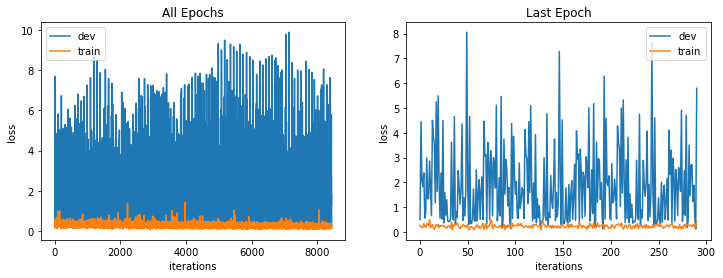

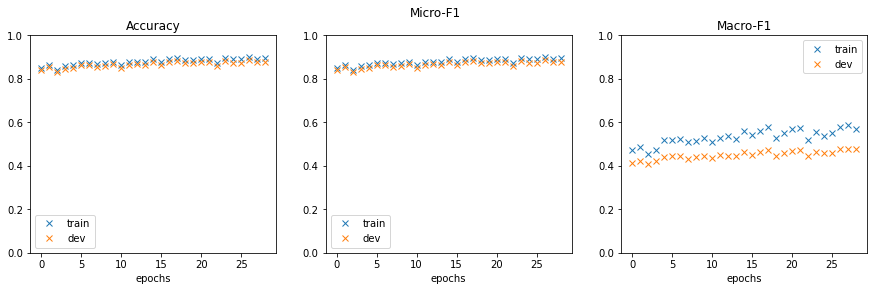

KeyboardInterrupt: 

In [169]:
train_loop(train_X, train_Y, dev_X, dev_Y,
           model=rand_tok_emb_ner_model.to(device),
           opt=optim.Adam(rand_tok_emb_ner_model.parameters(), lr=0.001),
           n_classes=len(lbl_to_id)-1,
           batch_size=128,
           grad_clip_norm=5)

In [176]:
#torch.save(rand_tok_emb_ner_model.state_dict(), 'data/pt-cache/rand_tok_emb_ner_model.pt')

In [170]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
glv_tok_emb_ner_model = NERModel(
    nn.Embedding.from_pretrained(
        glv_emb,
        freeze=False,
        padding_idx=tok_to_id['PAD_TOK']
    ),
    SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#rand_tok_emb_ner_model.load_state_dict(torch.load('data/pt-cache/glv_tok_emb_model.pt'))

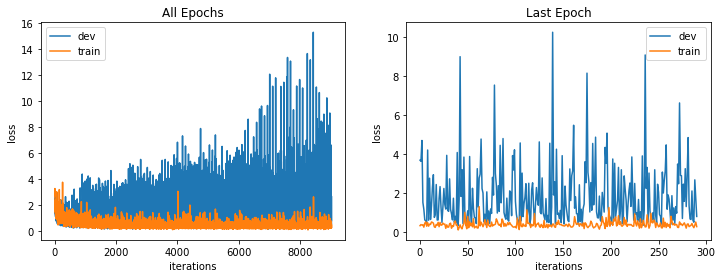

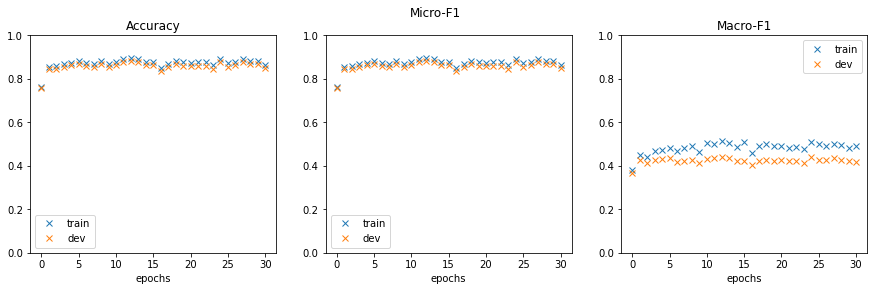

KeyboardInterrupt: 

In [172]:
train_loop(train_X, train_Y, dev_X, dev_Y,
           model=glv_tok_emb_ner_model.to(device),
           opt=optim.Adam(glv_tok_emb_ner_model.parameters(), lr=0.01),
           n_classes=len(lbl_to_id)-1,
           batch_size=128,
           grad_clip_norm=5)

In [174]:
#torch.save(glv_tok_emb_ner_model.state_dict(), 'data/pt-cache/glv_tok_emb_ner_model.pt')